<a href="https://colab.research.google.com/github/gogbob/pianoconversion/blob/main/AI%20pianotranscriber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip show librosa

Name: librosa
Version: 0.10.2.post1
Summary: Python module for audio and music processing
Home-page: https://librosa.org
Author: Brian McFee, librosa development team
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: /usr/local/lib/python3.10/dist-packages
Requires: audioread, decorator, joblib, lazy-loader, msgpack, numba, numpy, pooch, scikit-learn, scipy, soundfile, soxr, typing-extensions
Required-by: 


In [ ]:
!pip install ipdb

In [ ]:
import ipdb


In [2]:
!pip install mido==1.2.9
from mido import MidiFile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.1 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
#theme

audio_files = sorted(glob('../content/gdrive/MyDrive/wav_44100_stereo/*.wav'))
midi_files = sorted(glob('../content/gdrive/MyDrive/midi_files/*.mid'))

#import audio


In [4]:
for i in range(len(midi_files)):
  file_midi = (midi_files[i].split('/'))
  file_wav = (audio_files[i].split('/'))
  name_wav = (file_wav[len(file_wav) - 1]).split('.')[0]
  name_midi = (file_midi[len(file_midi) - 1]).split('.')[0]

  if name_wav != name_midi:
    ipdb.set_trace()
  a = 0

In [5]:
def getmidioutputforAI(midi_file, framespersecond, buffer, totalseconds):
  y_size = 128
  note_tracker = []

  track = MidiFile(midi_file).tracks[1]
  totalsize = 0
  timesum = 0
  timecounttemp = 0
  foundnote = False
  velocities = []
  for i in track:
    totalsize += i.time
  initframespersec = 960
  constant_k = initframespersec/framespersecond
  msgind = 0
  while not foundnote:
    timecounttemp += track[msgind].time
    if  track[msgind].type == 'note_on':
      timesum = (int)(-(timecounttemp) + buffer * initframespersec)
      foundnote = True
    msgind += 1
  totalsize -= timesum
  size_blur = (int)(totalsize/constant_k) + 1

  output_labels = np.zeros((size_blur, y_size))

  prev_time = 0
  #finds first note


  isPedal = False
  for msg in track:


    timesum += msg.time

    #fill places with no onset with held notes
    for t in range((int)(prev_time/constant_k), (int)(timesum/constant_k) + 1):
      n = 0
      while n < len(note_tracker):
        output_labels[t][note_tracker[n]] = velocities[n]/128
        velocities[n] -= 2
        if velocities[n] < 0: velocities[n] = 0
        n += 1
    prev_time = timesum

    if msg.type == 'note_on':


      #if a note turned on or off
      isPresent = False
      index = 0
      while index < len(note_tracker) and not isPresent:
        if note_tracker[index] == msg.note:
          #if note is turned on
          isPresent = True
          note_tracker.remove(note_tracker[index])
          velocities.remove(velocities[index])
        index += 1

      if not isPresent:
        time_blur = (int)(timesum/constant_k)
        #if note is turned off
        note_tracker.append(msg.note)
        velocities.append(msg.velocity)
  return output_labels

In [32]:
def splitArray(arr, sizex, overlap):
  splittings = []
  for i in range((int)((len(arr) - overlap)/(sizex - overlap))):
    start_index = i * (sizex - overlap)
    splittings.append(arr[start_index:start_index + sizex])
  return splittings

In [7]:
def fitmidwav(mids, wavs, numinoutperbatch, framespersec, framesperexerpt, framesoverlap, seqlen):
  compiled_mid_sequences = []
  compiled_wav_sequences = []
  for i in range(min(len(mids), len(wavs))):
    buffer = 0.1
    print('here')
    y, sr = librosa.load(wavs[i], sr = 22050)
    nfft = 2048
    onset_detect = librosa.onset.onset_detect(y=y, sr=sr)
    onset_wav = librosa.frames_to_time(onset_detect[0]) - buffer
    mel = librosa.feature.melspectrogram(y=y[(int)(onset_wav * sr):len(y)], sr=sr, n_fft=nfft, hop_length=(int)(sr/framespersec), n_mels=128, power=1)

    frames = getmidioutputforAI(mids[i], framespersec, buffer, librosa.get_duration(y=y, sr=sr))


    print(frames.shape)
    print(mel.shape)
    new_mel = np.zeros((mel.shape[1], mel.shape[0]))
    for j in range(len(mel)):
      for k in range(len(mel[i])):
        new_mel[k][j] = mel[j][k]

    print(frames.shape)
    print(new_mel.shape)

    lensequence = (int)(seqlen * (framesperexerpt - framesoverlap) + framesoverlap)

    frames = np.concatenate((frames, np.zeros(((int)(np.ceil(len(frames)/lensequence) * lensequence) - len(frames), 128))))
    new_mel = np.concatenate((new_mel, np.zeros(((int)(np.ceil(len(new_mel)/lensequence) * lensequence) - len(new_mel), 128))))

    print(frames.shape)
    print(new_mel.shape)

    #ipdb.set_trace()
    #midi split
    for j in range((min((int)((len(new_mel))/(lensequence)), (int)((len(frames))/(lensequence))))):
      compiled_mid_sequences.append(splitArray(frames[j * lensequence:j * lensequence + lensequence],
                                   framesperexerpt, framesoverlap))

      compiled_wav_sequences.append(splitArray(new_mel[(int)(j * lensequence):(int)(j * lensequence + lensequence)],
       framesperexerpt,
        framesoverlap))
      #ipdb.set_trace()



  listindecesnot_used = list(range(0, min(len(compiled_mid_sequences), len(compiled_wav_sequences))))

  batchX = []
  batchY = []
  for i in range(len(listindecesnot_used)):
    index_list = np.random.randint(0, len(listindecesnot_used))
    act_index = listindecesnot_used[index_list]
    X = compiled_wav_sequences[act_index]
    Y = compiled_mid_sequences[act_index]
    print(np.array(Y).shape)
    listindecesnot_used.remove(act_index)
    batchX.append(X)
    batchY.append(Y)
  #print(np.array(batchX).shape)
  #print(np.array(batchY).shape)
  #history = model.fit(np.array(batchX), np.array(batchY), batch_size=numinoutperbatch)
  #ipdb.set_trace()

  return batchX, batchY #history


In [33]:
#tf.debugging.set_log_device_placement(False)
h = []
print(midi_files[0:1])
print(audio_files[0:1])
x, y = fitmidwav(midi_files[0:1], audio_files[0:1], 100, 20, 10, 5, 2)

#model.export('../gdrive/MyDrive/', format='myai')

['../content/gdrive/MyDrive/midi_files/Bach_BWV849-01_001_20090916-SMD.mid']
['../content/gdrive/MyDrive/wav_44100_stereo/Bach_BWV849-01_001_20090916-SMD.wav']
here
(3180, 128)
(128, 3092)
(3180, 128)
(3092, 128)
(3180, 128)
(3105, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 128)
(2, 10, 1

In [ ]:
y_l, sr = librosa.load(audio_files[0], sr = 22050)
onset_detect = librosa.onset.onset_detect(y=y_l, sr=sr)
onset_wav = librosa.frames_to_time(onset_detect[0]) - 0.1
mel_l = librosa.feature.melspectrogram(y=y_l[(int)(onset_wav * sr):len(y_l)], sr=sr, hop_length=(int)(sr/50), n_mels=256, power=1)
ranger = 256
new_mel_l = np.zeros((mel_l.shape[0], ranger))
print(new_mel_l)
length = len(new_mel_l)

for l in range(ranger):
  for p in range(len(new_mel_l[i])):
    new_mel_l[p][l] = mel_l[p][l]
plt.imshow(new_mel_l, cmap='viridis')

plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


IndexError: index 256 is out of bounds for axis 0 with size 256

(5, 10, 128)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
(104, 5, 10, 128)


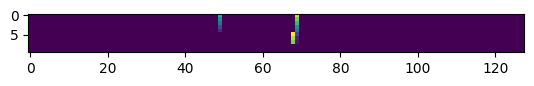

In [18]:
print(np.array(y[0]).shape)
for i in range(len(x)):
  if np.array(y[i]).shape != (5, 150, 128): print(i)
print(np.array(y).shape)
plt.imshow(y[2][0], cmap='viridis')

plt.show()

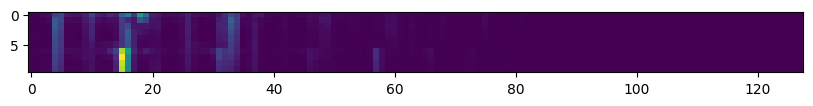

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

plt.imshow(x[2][0])
plt.show()



In [42]:
import tensorflow as tf
from tensorflow import keras
tf.config.set_visible_devices([], 'GPU')

kernel_size = (5,5)

out_x = 10
out_y = 128
n_mels = 256
trainseqsize = 2
sec_perseq = 0.5
sr = 22050
in_x = 10
in_y = 128
filters1 = 2
filters2 = 8
shaper = (trainseqsize, in_x, in_y)

mem_alloc = 2


input_tensor = keras.Input(shape=shaper, batch_size=None)

list_convs = []
for i in range(trainseqsize):
  out =  keras.layers.Lambda(lambda x: x[:, i, :, :]) (input_tensor)
  out = keras.layers.Reshape(target_shape=(out.shape[1], out.shape[2], 1))(out)
  conv = keras.layers.Conv2D(filters1, kernel_size, data_format='channels_last') (out)
  conv = keras.layers.Reshape(target_shape=(1, conv.shape[1], conv.shape[2], conv.shape[3]))(conv)
  list_convs.append(conv)
stacked_tensors_frame = keras.layers.Concatenate(axis=1)(list_convs)
print(stacked_tensors_frame.shape)
flatten_frame = keras.layers.Reshape(target_shape=(stacked_tensors_frame.shape[1], stacked_tensors_frame.shape[2] * stacked_tensors_frame.shape[3] * stacked_tensors_frame.shape[4])) (stacked_tensors_frame)
dense1_frame = keras.layers.Dense(out_y * out_x, activation='sigmoid') (flatten_frame)
frame_branch = keras.layers.Dense(out_y * out_x, activation='sigmoid') (dense1_frame)

biLSTM_frame = keras.layers.Bidirectional(keras.layers.LSTM(out_x * 50, return_sequences=True, activation='sigmoid', recurrent_activation='sigmoid'), merge_mode='concat')(frame_branch)
dense2_frame = keras.layers.Dense(out_x * out_y * 10, activation='sigmoid') (biLSTM_frame)
dense2_frame = keras.layers.Dense(out_x * out_y * 10, activation='sigmoid') (dense2_frame)
dense2_frame = keras.layers.Dense(out_x * out_y * 10, activation='sigmoid') (dense2_frame)
dense2_frame = keras.layers.Dense(out_x * out_y, activation='sigmoid') (dense2_frame)
output = keras.layers.Reshape(target_shape=(trainseqsize, out_x, out_y)) (dense2_frame)


model = keras.Model(inputs=input_tensor, outputs=output)

model.summary()

(None, 2, 6, 124, 2)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 2, 10, 128)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_17 (Lambda)        │ (None, 10, 128)        │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_18 (Lambda)        │ (None, 10, 128)        │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_42 (Reshape)      │ (None, 10, 128, 1)     │              0 │ lambda_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_44 (Reshape)      │ (None, 10, 128, 1)     │              0 │ lambda_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 6, 124, 2)      │             52 │ reshape_42[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 6, 124, 2)      │             52 │ reshape_44[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_43 (Reshape)      │ (None, 1, 6, 124, 2)   │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_45 (Reshape)      │ (None, 1, 6, 124, 2)   │              0 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 2, 6, 124, 2)   │              0 │ reshape_43[0][0],      │
│ (Concatenate)             │                        │                │ reshape_45[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_46 (Reshape)      │ (None, 2, 1488)        │              0 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 2, 1280)        │      1,905,920 │ reshape_46[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 2, 1280)        │      1,639,680 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 2, 1000)        │      7,124,000 │ dense_17[0][0]         │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 2, 12800)       │     12,812,800 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 2, 12800)       │    163,852,800 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 2, 12800)       │    163,852,800 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 2, 1280)        │     16,385,280 │ dense_20[0][0]         │
├──────────────────────

 Total params: 367,573,384 (1.37 GB)

 Trainable params: 367,573,384 (1.37 GB)

 Non-trainable params: 0 (0.00 B)

In [43]:

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

In [44]:
model.fit(np.array(x[0:1]), np.array(y[0:1]), epochs = 50)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 1.9847
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.4277
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.3639
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.3570
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.3478
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.3498
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.3513
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3522
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.3525
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.3523
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.3518
Epoch 12/50


KeyboardInterrupt: 

In [14]:
!pip install midiutil
import os
#sample code
file = 'out.mid'
from midiutil.MidiFile import MIDIFile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54569 sha256=51a4f77f247854d39f349c185a93ad2ef0d929ae2048a5c295d947b416c0888e
  Stored in directory: /root/.cache/pip/wheels/af/43/4a/00b5e4f2fe5e2cd6e92b461995a3a97a2cebb30ab5783501b0
Successfully built midiutil


In [21]:

def deNoise(output, file):


  with open(os.path.join('../content/gdrive/MyDrive/', file), 'w') as fp:
    pass
  for i in range(len(output)):
    for j in range(len(output[i])):
      if output[i][j] > 0.05:
        output[i][j] = output[i][j]
      else:
        output[i][j] = 0
  #do groupings
  stillGroupings = True
  index = 0
  current_timeSaved = 0
  mf = MIDIFile(1)     # only 1 track
  track = 0   # the only track

  time = 0    # start at the beginning
  mf.addTrackName(track, time, "Sample Track")
  mf.addTempo(track, time, 120)

  # add some notes
  channel = 0
  backlog = []
  while stillGroupings:
    #ipdb.set_trace()
    #find first note
    foundFirstNote = False
    firstNote = []
    for i in range(len(output)):
      for j in range(len(output[i])):
        if output[i][j] > 0.05 and not foundFirstNote:
          foundFirstNote = True
          firstNote = [i, j]


    groupEnd = False
    if not foundFirstNote:
      stillGroupings = False
    else:
      biggestvelocity = output[firstNote[0]][firstNote[1]]
      groupIndex = 0
      lastNote = [firstNote[0] + 1, firstNote[1]]
      while not groupEnd:
        if firstNote[0] + groupIndex + 3 >= len(output):
          groupEnd = True
          lastNote = [len(output), firstNote[1]]
        else:
          biggestvelocity = max((biggestvelocity, output[firstNote[0] + groupIndex + 1][firstNote[1]], output[firstNote[0] + groupIndex + 2][firstNote[1]], output[firstNote[0] + groupIndex + 3][firstNote[1]]))

          if output[firstNote[0] + groupIndex + 1][firstNote[1]] <= 0.05 and output[firstNote[0] + groupIndex + 2][firstNote[1]] <= 0.05 and output[firstNote[0] + groupIndex + 3][firstNote[1]] <= 0.05:
            groupEnd = True
          else:
            lastNote = [firstNote[0] + groupIndex + 1, firstNote[1]]
            groupIndex += 1
      if firstNote[0] == 1 and firstNote[1] == 76:  ipdb.set_trace()
      for i in range(lastNote[0] - firstNote[0]):
        if firstNote[0] == 1 and firstNote[1] == 76:  ipdb.set_trace()
        output[firstNote[0] + i][firstNote[1]] = 0
      # create your MIDI object
      #ipdb.set_trace()

      pitch = firstNote[1]           # C4 (middle C)
      time = firstNote[0]          # start on beat 0
      duration = lastNote[0] - firstNote[0]         # 1 beat long
      mf.addNote(track, channel, pitch, time * 48, duration, (int)(biggestvelocity * 128))
      print('added note (' + str(time) + ', ' + str(pitch) + ') at ' + str((int)(biggestvelocity * 128)) + ' velocity')
  with open('../content/gdrive/MyDrive/' + file, 'wb') as outf:
    mf.writeFile(outf)
  index += 1





In [45]:
raw_output = model.predict_on_batch(np.array(x[0:1]))

print(raw_output.shape)

output = np.zeros((1 * (10 - 5) + 10, 128))
for i in range(len(output)):
  for j in range(128):
    if i >= 5 and i < 1 * (10 - 5) + 5:
      output[i][j] = (raw_output[0][(int)((i - 5) / 5)][5 + i % 5][j]) / 2 + (raw_output[0][(int)((i - 5) / 5) + 1][i % 10][j]) / 2
    else:
      if i >= 5:
        output[i][j] = raw_output[0][(int)((i - 5) / 5)][i % 5][j]
      else:
        output[i][j] = raw_output[0][(int)(i / 5)][i % 5][j]



deNoise(output, 'out.mid')

(1, 2, 10, 128)
added note (0, 56) at 128 velocity
added note (0, 84) at 128 velocity
added note (4, 54) at 128 velocity
added note (9, 54) at 128 velocity
added note (14, 54) at 128 velocity


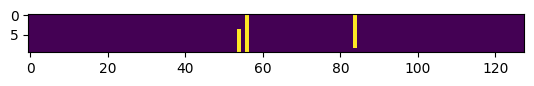

In [47]:
plt.imshow(raw_output[0][1])
plt.show()


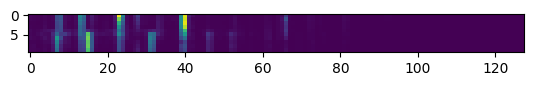

In [38]:
plt.imshow(x[0][0])
plt.show()

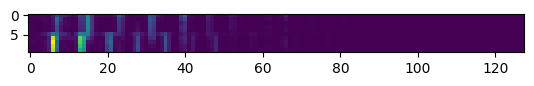

In [39]:
plt.imshow(x[0][1])
plt.show()

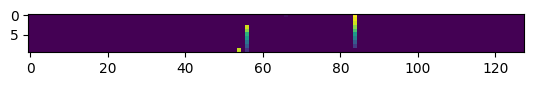

In [40]:
plt.imshow(y[0][0])
plt.show()

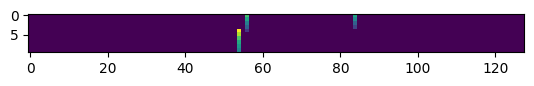

In [41]:
plt.imshow(y[0][1])
plt.show()